In [1]:
import pandas as pd 
import numpy as np 
import re
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture

In [2]:
df_embeddings = pd.read_excel('/Users/axhermosillo/Desktop/Tec/8vo Semestre/Bloque Integrador/CV_Classifier/CVClassifier/output.xlsx', sheet_name='Embeddings')
df_cvs = pd.read_excel('/Users/axhermosillo/Desktop/Tec/8vo Semestre/Bloque Integrador/CV_Classifier/CVClassifier/output.xlsx', sheet_name='CVs')

In [36]:
def get_top_k_cluster_frequencies(df, groupby, cluster_column, k=5):
    """
    Returns the frequency of clusters grouped by groupby
    """
    batches = []
    df_group = df.groupby(groupby)
    df_group.apply(lambda x: batches.append(x[cluster_column].value_counts().head(k)))  #include_groups=False
    return batches


def get_appereances(freq_list):
    """
    Get the number of appereances of each cluster in all the lists
    """
    appereances = {}
    for batch in freq_list:
        for number in batch.index.values:
            if number in appereances.keys():
                appereances[number] += 1
            else:
                appereances[number] = 1
        # [appereances[number] += 1 for number in batch.index.values]
        # print(batch.index.values)
    return pd.Series(appereances)


def get_sentences_in_cluster(df, sentence_column, cluster_column, cluster):
    """
    Returns the tokens that are related to one cluster
    """
    return df[df[cluster_column] == cluster][sentence_column]


def convert_for_training(df, df_norm, num_clusters):
    """
    Extract the features and generate a matrix with CVs as the rows and frequency of clusters as the columns.
    """
    keys = df['index'].unique()
    X = {k: np.zeros(num_clusters+1) for k in keys}
    
    for _, row in df.iterrows():
        X[row['index']][row['cluster']] += 1
    
    for key, value in X.items():
        X[key][ :-1] = X[key][ :-1] / df_norm.iloc[key] if df_norm.iloc[key] != 0 else X[key][ :-1]
        X[key][-1] = df_norm.iloc[key] / 100
    
    df_result = pd.DataFrame(X)

    return df_result.T

def convert_embedding(embedding_str):
    embedding_str = embedding_str.strip('[]')
    if embedding_str[0] == ' ':
        embedding_str = embedding_str[1:]
    embedding_list = re.split(r'\s+', embedding_str)
    embedding_array = np.array([float(x) for x in embedding_list if x], dtype=float)
    return embedding_array


In [4]:
print('Embeddings:')
display(df_embeddings.head())
print(df_embeddings.shape)
print(df_embeddings.dtypes)

print('CVs:')
display(df_cvs.head())
print(df_cvs.shape)
print(df_cvs.dtypes)


Embeddings:


,label,index,sentence,embedding,len
0,Gerente,0,leader experience supply chain quality leaders...,[-4.47424054e-02 2.24276166e-02 5.02501056e-...,57
1,Gerente,0,o id na project implementation emphasis manage...,[-2.00967677e-02 5.39981909e-02 -2.66174022e-...,57
2,Gerente,0,economic human lean pharmaceutical chemist neg...,[-3.60780656e-02 -1.95347006e-03 -3.81188877e-...,57
3,Gerente,0,address diagonal house mail hot mail understan...,[-7.89540994e-04 1.34884324e-02 5.60681103e-...,57
4,Gerente,0,customer need decision making conflict resolut...,[-3.67572196e-02 1.91883203e-02 1.27373321e-...,57


(80167, 5)
label        object
index         int64
sentence     object
embedding    object
len           int64
dtype: object
CVs:


,label,index,text
0,Gerente,0,leader experience supply chain quality leaders...
1,Gerente,1,profile chemical engineer experience project m...
2,Gerente,2,yahoo cell graduate public accounting speciali...
3,Gerente,3,mechanical electrical engineer contact rel coa...
4,Gerente,4,environmental health safety manager risk manag...


(2065, 3)
label    object
index     int64
text     object
dtype: object


In [24]:
lst = list(set(df_embeddings['index']))
lst[-1]

2079

In [26]:
def find_missing_values(nums, n):
    full_set = set(range(n + 1))    
    nums_set = set(nums)
    
    missing_values = full_set - nums_set
    
    return sorted(list(missing_values))

nums = df_cvs['index']
n = 2079
missing_values = find_missing_values(nums, n)
print(missing_values)
print(f'{100 - len(missing_values)/2079*100:.2f} %')


[1407, 1411, 1413, 1414, 1416, 1417, 1420, 1421, 1422, 1425, 1430, 1431, 1435, 1436, 1437]
99.28 %


In [6]:
df = df_embeddings.copy()

In [7]:
df['embedding'] =df['embedding'].apply(convert_embedding)
display(df.head())
print(df_embeddings.dtypes)

,label,index,sentence,embedding,len
0,Gerente,0,leader experience supply chain quality leaders...,"[-0.0447424054, 0.0224276166, 0.0502501056, 0....",57
1,Gerente,0,o id na project implementation emphasis manage...,"[-0.0200967677, 0.0539981909, -0.0266174022, -...",57
2,Gerente,0,economic human lean pharmaceutical chemist neg...,"[-0.0360780656, -0.00195347006, -0.0381188877,...",57
3,Gerente,0,address diagonal house mail hot mail understan...,"[-0.000789540994, 0.0134884324, 0.00560681103,...",57
4,Gerente,0,customer need decision making conflict resolut...,"[-0.0367572196, 0.0191883203, 0.00127373321, -...",57


label        object
index         int64
sentence     object
embedding    object
len           int64
dtype: object


In [18]:
print(df.shape)

(80167, 6)


In [8]:
kmeans = KMeans(n_clusters=30, random_state=0, n_init="auto").fit(df['embedding'].to_list())
df['cluster'] = kmeans.labels_
df.head()

,label,index,sentence,embedding,len,cluster
0,Gerente,0,leader experience supply chain quality leaders...,"[-0.0447424054, 0.0224276166, 0.0502501056, 0....",57,13
1,Gerente,0,o id na project implementation emphasis manage...,"[-0.0200967677, 0.0539981909, -0.0266174022, -...",57,28
2,Gerente,0,economic human lean pharmaceutical chemist neg...,"[-0.0360780656, -0.00195347006, -0.0381188877,...",57,3
3,Gerente,0,address diagonal house mail hot mail understan...,"[-0.000789540994, 0.0134884324, 0.00560681103,...",57,22
4,Gerente,0,customer need decision making conflict resolut...,"[-0.0367572196, 0.0191883203, 0.00127373321, -...",57,13


In [9]:
cluster_freq = get_top_k_cluster_frequencies(df[df['label'] == 'Director'], groupby='index', cluster_column='cluster')
director_appereances = get_appereances(cluster_freq)
director_appereances = director_appereances.sort_values(ascending=False).head(5)

cluster_freq = get_top_k_cluster_frequencies(df[df['label'] == 'Gerente'], groupby='index', cluster_column='cluster')
gerente_appereances = get_appereances(cluster_freq)
gerente_appereances = gerente_appereances.sort_values(ascending=False).head(5)

cluster_freq = get_top_k_cluster_frequencies(df[df['label'] == 'Especialista'], groupby='index', cluster_column='cluster')
especialista_appereances = get_appereances(cluster_freq)
especialista_appereances = especialista_appereances.sort_values(ascending=False).head(5)

In [10]:
print('Director:')
print(director_appereances)

print('Gerente:')
print(gerente_appereances)

print('Especialista:')
print(especialista_appereances)

Director:
10    27
6     19
22    19
8     19
28    17
dtype: int64
Gerente:
10    563
8     470
18    439
28    398
12    383
dtype: int64
Especialista:
11    172
22    160
16    145
9     133
20    118
dtype: int64


In [37]:
X = convert_for_training(df, df['len'], num_clusters=30)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.017544,0.052632,0.000000,0.140351,0.000000,0.017544,0.000000,0.052632,0.122807,0.000000,...,0.017544,0.017544,0.017544,0.000000,0.000000,0.000000,0.000000,0.070175,0.017544,0.57
1,0.000000,0.000000,0.017544,0.017544,0.000000,0.000000,0.000000,0.000000,0.122807,0.035088,...,0.035088,0.017544,0.000000,0.070175,0.017544,0.000000,0.017544,0.087719,0.000000,0.57
2,0.000000,0.052632,0.035088,0.000000,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,...,0.000000,0.000000,0.000000,0.315789,0.035088,0.035088,0.000000,0.087719,0.000000,0.57
3,0.000000,0.017544,0.000000,0.017544,0.017544,0.000000,0.000000,0.000000,0.070175,0.035088,...,0.017544,0.000000,0.000000,0.035088,0.035088,0.017544,0.000000,0.000000,0.000000,0.57
4,0.017544,0.017544,0.035088,0.017544,0.017544,0.000000,0.035088,0.017544,0.017544,0.000000,...,0.105263,0.000000,0.000000,0.000000,0.035088,0.017544,0.000000,0.035088,0.105263,0.57


In [38]:
X

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.017544,0.052632,0.000000,0.140351,0.000000,0.017544,0.000000,0.052632,0.122807,0.000000,...,0.017544,0.017544,0.017544,0.000000,0.000000,0.000000,0.000000,0.070175,0.017544,0.57
1,0.000000,0.000000,0.017544,0.017544,0.000000,0.000000,0.000000,0.000000,0.122807,0.035088,...,0.035088,0.017544,0.000000,0.070175,0.017544,0.000000,0.017544,0.087719,0.000000,0.57
2,0.000000,0.052632,0.035088,0.000000,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,...,0.000000,0.000000,0.000000,0.315789,0.035088,0.035088,0.000000,0.087719,0.000000,0.57
3,0.000000,0.017544,0.000000,0.017544,0.017544,0.000000,0.000000,0.000000,0.070175,0.035088,...,0.017544,0.000000,0.000000,0.035088,0.035088,0.017544,0.000000,0.000000,0.000000,0.57
4,0.017544,0.017544,0.035088,0.017544,0.017544,0.000000,0.035088,0.017544,0.017544,0.000000,...,0.105263,0.000000,0.000000,0.000000,0.035088,0.017544,0.000000,0.035088,0.105263,0.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,0.000000,0.000000,0.019417,0.000000,0.000000,0.000000,0.029126,0.000000,0.029126,0.038835,...,0.019417,0.009709,0.048544,0.000000,0.000000,0.000000,0.000000,0.029126,0.000000,1.03
2076,0.000000,0.000000,0.000000,0.000000,0.000000,0.048544,0.029126,0.009709,0.019417,0.000000,...,0.000000,0.019417,0.009709,0.000000,0.009709,0.000000,0.000000,0.077670,0.000000,1.03
2077,0.000000,0.009709,0.000000,0.000000,0.000000,0.038835,0.000000,0.000000,0.000000,0.009709,...,0.000000,0.000000,0.009709,0.000000,0.009709,0.000000,0.000000,0.000000,0.000000,1.03
2078,0.000000,0.009709,0.000000,0.000000,0.009709,0.029126,0.000000,0.000000,0.058252,0.000000,...,0.000000,0.038835,0.009709,0.000000,0.019417,0.019417,0.000000,0.000000,0.000000,1.03


In [39]:
useful_clusters = pd.concat([director_appereances, especialista_appereances, gerente_appereances])
lst_useful_clusters = list(set(useful_clusters.index))
lst_useful_clusters

[6, 8, 9, 10, 11, 12, 16, 18, 20, 22, 28]

In [40]:
X_pro = X.loc[:, lst_useful_clusters]
X_pro

,6,8,9,10,11,12,16,18,20,22,28
0,0.000000,0.122807,0.000000,0.140351,0.000000,0.035088,0.017544,0.000000,0.017544,0.017544,0.070175
1,0.000000,0.122807,0.035088,0.052632,0.000000,0.017544,0.017544,0.087719,0.017544,0.017544,0.087719
2,0.000000,0.035088,0.000000,0.052632,0.035088,0.157895,0.000000,0.017544,0.035088,0.000000,0.087719
3,0.000000,0.070175,0.035088,0.017544,0.035088,0.017544,0.000000,0.000000,0.017544,0.000000,0.000000
4,0.035088,0.017544,0.000000,0.070175,0.070175,0.052632,0.052632,0.000000,0.017544,0.000000,0.035088
...,...,...,...,...,...,...,...,...,...,...,...
2075,0.029126,0.029126,0.038835,0.019417,0.009709,0.000000,0.000000,0.000000,0.000000,0.009709,0.029126
2076,0.029126,0.019417,0.000000,0.058252,0.048544,0.000000,0.000000,0.000000,0.009709,0.019417,0.077670
2077,0.000000,0.000000,0.009709,0.029126,0.019417,0.000000,0.000000,0.000000,0.009709,0.000000,0.000000
2078,0.000000,0.058252,0.000000,0.000000,0.097087,0.009709,0.000000,0.009709,0.009709,0.038835,0.000000


In [41]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

y = label_encoder.fit_transform(df_cvs['label'])
print(y.shape)
y

(2065,)


array([2, 2, 2, ..., 1, 1, 1])

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X_ld = np.array(X)
clf = LDA()
model = clf.fit(X_ld, y).transform(X_ld)
clf.score(X_ld, y)

0.7932203389830509

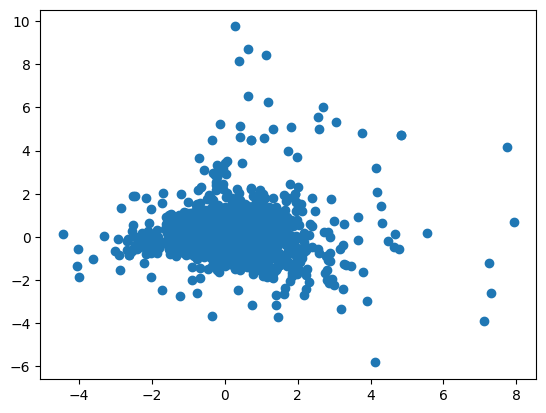

In [43]:
import matplotlib.pyplot as plt 

x_lda = (model[:, 0])
y_lda = (model[:, 1])

plt.scatter(x_lda, y_lda)

Text(0.5, 1.0, 'LDA')

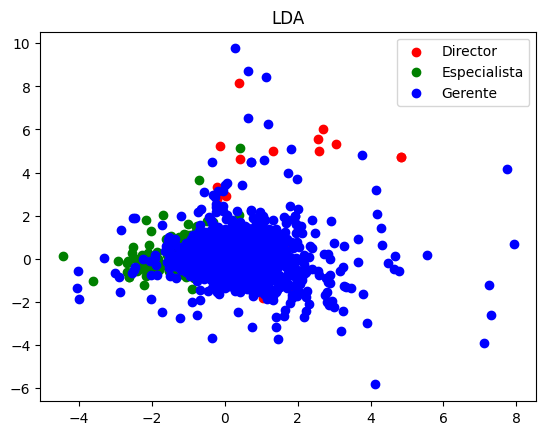

In [44]:
target_names = ['Director', 'Especialista', 'Gerente']
target_names = np.array(target_names)

for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(model[y == i, 0], model[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA')

In [46]:
df_g = df_cvs[df_cvs['label'] == 'Gerente']
df_d = df_cvs[df_cvs['label'] == 'Director']
df_e = df_cvs[df_cvs['label'] == 'Especialista']

print(df_g.shape)
print(df_d.shape)
print(df_e.shape)

(1622, 3)
(55, 3)
(388, 3)


In [106]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ld, y, test_size=.14,random_state =123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)


  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [00:08<00:00,  2.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1775, number of used features: 31
[LightGBM] [Info] Start training from score -3.652914
[LightGBM] [Info] Start training from score -1.661473
[LightGBM] [Info] Start training from score -0.243059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:09<00:00,  3.08it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.96               0.94    None      0.96   
XGBClassifier                      0.95               0.93    None      0.95   
AdaBoostClassifier                 0.64               0.71    None      0.68   


In [63]:
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier

estimator = LGBMClassifier()
selector = RFE(estimator, n_features_to_select=15, step=1)
selector = selector.fit(X_train, y_train)
mask = list(selector.support_)

X_pro = X.loc[:, mask]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3199
[LightGBM] [Info] Number of data points in the train set: 1652, number of used features: 31
[LightGBM] [Info] Start training from score -3.625552
[LightGBM] [Info] Start training from score -1.669949
[LightGBM] [Info] Start training from score -0.241933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_pro, y, test_size=.29,random_state =123)

clf = LGBMClassifier()
pred_score = clf.fit(X_train, y_train).score(X_test, y_test)

print(pred_score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1600
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 15
[LightGBM] [Info] Start training from score -3.626731
[LightGBM] [Info] Start training from score -1.669892
[LightGBM] [Info] Start training from score -0.241906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli